### Student information:
- Name: Vineet Kumar
- Roll No.: 2024AC05100
- Assignment-1: Video Classification

### Assignment objective: 

Using the customized dataset "UCF-101" to perform "Action recognition" for 3 different classes to predict the correct video class (Video Classification) using Classical Machine learning and Deep Learning Models.

### Task: Action recognition:
1. Using Classical Machine Learning models.
2. Using Deep Learning Models

### This python notebook file contains the code for following tasks:
1. Loading the dataset for 3 classes:
    - Class-1: PullUps
    - Class-2: Punch
    - Class-3: PullUps
    - The dataset is split into Train, Test and Validation.
    - For each category there is a separate CSV file.
2. Implementation of Deep Learning Learning models like 2D-CNN and 3D-CNN etc.
3. Model hyperparameter tuning
4. Performance evaluation and comparison

### Environment Setup

1. Installing required modules

- Before running this notebook, install dependencies using:
> `pip install -r requirements.txt`

- (Ignore if already done)

2. importing modules and basic setup

In [1]:
import os;
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from data_loader import VideoDataset2D
from models import ResNet18Temporal
from utils import train_one_epoch, eval_one_epoch, EarlyStopping
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
import random
import psutil
from data_loader import VideoDataset3D
from models import ResNet3D

from sklearn.metrics import precision_recall_fscore_support
import json
import time

3. Reproducibility and Random Seed Initialization

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

4. Creating required directories

In [3]:
os.makedirs("../results", exist_ok=True);
os.makedirs("../results/confusion_matrices", exist_ok=True);
os.makedirs("../results/confusion_matrices/deep_learning", exist_ok=True);
os.makedirs("../results/performance_plots", exist_ok=True);
os.makedirs("../results/performance_plots/deep_learning", exist_ok=True);
os.makedirs("../results/feature_visualizations", exist_ok=True);
os.makedirs("../results/saved_models", exist_ok=True);
os.makedirs("../results/saved_models/deep_learning", exist_ok=True);
os.makedirs("../results/stats_deep_learning", exist_ok=True);

5. Directory path for saving trained models

In [4]:

SAVE_DIR = "../results/saved_models/deep_learning";
os.makedirs(SAVE_DIR, exist_ok=True);

MODEL_2D_PATH = os.path.join(SAVE_DIR, "best_2d-cnn.pth");
MODEL_3D_PATH = os.path.join(SAVE_DIR, "best_3d-cnn.pth");


STATS_2D_PATH = "../results/stats_deep_learning/stats_2d.json";
STATS_3D_PATH = "../results/stats_deep_learning/stats_3d.json";

6. Transforms

In [5]:
train_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

7. Dataset & loaders

In [6]:
class_map = {"PullUps": 0, "Punch": 1, "PushUps": 2}
num_classes = len(class_map)

dataset_root = "../dataset_info/dataset"

train_ds_2d = VideoDataset2D("../dataset_info/dataset/splits/train.csv",
                         dataset_root, class_map,
                         num_frames=20, transform=train_tfms, train=True)

val_ds_2d = VideoDataset2D("../dataset_info/dataset/splits/val.csv",
                       dataset_root, class_map,
                       num_frames=20, transform=val_tfms, train=False)

test_ds_2d = VideoDataset2D("../dataset_info/dataset/splits/test.csv",
                        dataset_root, class_map,
                        num_frames=20, transform=val_tfms, train=False)

train_loader_2d = DataLoader(train_ds_2d, batch_size=4, shuffle=True, num_workers=4)
val_loader_2d   = DataLoader(val_ds_2d, batch_size=4, shuffle=False, num_workers=4)
test_loader_2d  = DataLoader(test_ds_2d, batch_size=4, shuffle=False, num_workers=4)


### Deep Learning Algorithms

Implementing following Deep Learning Models
- 2D-CNN - with temporal pooling (ResNet18 pretrained on ImageNet)
- 3D-CNN - pre-trained 3D ResNet-18 (R3D-18), which is an I3D-style 3D CNN architecture

------------------------------------------------------------------------

1. 2D CNN with Temporal Pooling
 - Use pre-trained 2D CNN (ResNet-18, ResNet-50, or EfficientNet-B0) for frame-level features
 - Extract features from sampled frames (e.g., 16-32 frames per video)


2D CNN: Model, optimizer and scheduler selection

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_2d = ResNet18Temporal(num_classes=num_classes, pooling="avg", dropout=0.5).to(device)


criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.9)

# Using Adam as optimizer
optimizer = torch.optim.Adam(model_2d.parameters(), lr=1e-4, weight_decay=1e-4)
# Learning rate scheduling
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
# Early stopping
early_stop = EarlyStopping(patience=3)


2D CNN: Training loop (with early stopping) 
- This will take around 30 minutes to complete.

In [8]:
start_time = time.time()

EPOCHS = 8
best_val_acc = 0.0

train_losses_2d = []
val_losses_2d   = []
train_accs_2d   = []
val_accs_2d     = []

# ================= LOAD IF EXISTS =================
if os.path.exists(MODEL_2D_PATH):

    print("Found saved 2D model. Loading...")

    model_2d.load_state_dict(torch.load(MODEL_2D_PATH, map_location=device))
    model_2d.to(device)
    model_2d.eval()

    if os.path.exists(STATS_2D_PATH):
        with open(STATS_2D_PATH, "r") as f:
            stats = json.load(f)

        # ---- SAFE LOAD (no KeyError) ----
        train_losses_2d = stats.get("train_losses", [])
        val_losses_2d   = stats.get("val_losses", [])
        train_accs_2d   = stats.get("train_accs", [])
        val_accs_2d     = stats.get("val_accs", [])
        best_val_acc    = max(val_accs_2d) if len(val_accs_2d) > 0 else 0.0

        print("Loaded training curves from stats_2d.json")
    else:
        print("stats_2d.json not found → curves unavailable")

# ================= TRAIN IF NOT EXISTS =================
else:
    print("No saved 2D model found. Starting training...")

    for epoch in trange(EPOCHS, desc="2D CNN Epochs"):

        train_loss, train_acc = train_one_epoch(
            model_2d, train_loader_2d, optimizer, criterion, device)

        val_loss, val_acc = eval_one_epoch(
            model_2d, val_loader_2d, criterion, device)

        scheduler.step()

        print(
            f"\nEpoch [{epoch+1}/{EPOCHS}] "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} || "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
        )

        train_losses_2d.append(train_loss)
        val_losses_2d.append(val_loss)
        train_accs_2d.append(train_acc)
        val_accs_2d.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model_2d.state_dict(), MODEL_2D_PATH)

        early_stop(val_loss)
        if early_stop.stop:
            print("⏹ Early stopping triggered")
            break

    print("2D CNN Training complete. Best Val Acc:", best_val_acc)

    # ================= SAVE TRAINING CURVES =================
    stats_2d = {
        "train_losses": train_losses_2d,
        "val_losses": val_losses_2d,
        "train_accs": train_accs_2d,
        "val_accs": val_accs_2d,
        "best_val_acc": best_val_acc
    }

    with open(STATS_2D_PATH, "w") as f:
        json.dump(stats_2d, f, indent=4)

    print("Training curves saved to stats_2d.json")

end_time = time.time()
train_time_2d = end_time - start_time

np.save("../results/stats_deep_learning/train_time_2d.npy", train_time_2d)
print("2D CNN Training Time (seconds):", train_time_2d)


No saved 2D model found. Starting training...


2D CNN Epochs:  12%|█▎        | 1/8 [07:21<51:32, 441.80s/it]


Epoch [1/8] Train Loss: 1.2189 | Train Acc: 0.4391 || Val Loss: 1.1740 | Val Acc: 0.4444


2D CNN Epochs:  25%|██▌       | 2/8 [15:12<45:51, 458.58s/it]


Epoch [2/8] Train Loss: 1.1574 | Train Acc: 0.4244 || Val Loss: 1.1128 | Val Acc: 0.4000


2D CNN Epochs:  38%|███▊      | 3/8 [22:57<38:28, 461.77s/it]


Epoch [3/8] Train Loss: 1.1278 | Train Acc: 0.4834 || Val Loss: 1.0941 | Val Acc: 0.8000


2D CNN Epochs:  50%|█████     | 4/8 [30:47<30:59, 464.82s/it]


Epoch [4/8] Train Loss: 1.1132 | Train Acc: 0.4317 || Val Loss: 1.0938 | Val Acc: 0.8667


2D CNN Epochs:  62%|██████▎   | 5/8 [38:35<23:18, 466.21s/it]


Epoch [5/8] Train Loss: 1.1100 | Train Acc: 0.5055 || Val Loss: 1.0925 | Val Acc: 0.9333


2D CNN Epochs:  75%|███████▌  | 6/8 [46:21<15:32, 466.12s/it]


Epoch [6/8] Train Loss: 1.1095 | Train Acc: 0.4613 || Val Loss: 1.0934 | Val Acc: 0.8889


2D CNN Epochs:  88%|████████▊ | 7/8 [54:07<07:46, 466.14s/it]


Epoch [7/8] Train Loss: 1.1073 | Train Acc: 0.5683 || Val Loss: 1.0918 | Val Acc: 0.9556


2D CNN Epochs: 100%|██████████| 8/8 [1:01:57<00:00, 464.73s/it]


Epoch [8/8] Train Loss: 1.1057 | Train Acc: 0.5793 || Val Loss: 1.0913 | Val Acc: 0.9333
2D CNN Training complete. Best Val Acc: 0.9555555555555556
Training curves saved to stats_2d.json
2D CNN Training Time (seconds): 3717.864061832428


2D CNN: Loading best model

In [9]:
# Load best saved model
model_2d.load_state_dict(torch.load(MODEL_2D_PATH, map_location=device))
model_2d.eval()

print("Model loaded successfully")
print("Backbone: ResNet-18 (ImageNet pretrained)")
print("Input: fixed-length RGB frame sequences (224x224)")
print("Temporal aggregation: Temporal pooling")
print("Classifier head: Dropout → Fully Connected (3 classes)")

print("Trainable parameters:",
      sum(p.numel() for p in model_2d.parameters() if p.requires_grad))

print("Total parameters:",
      sum(p.numel() for p in model_2d.parameters()))



Model loaded successfully
Backbone: ResNet-18 (ImageNet pretrained)
Input: fixed-length RGB frame sequences (224x224)
Temporal aggregation: Temporal pooling
Classifier head: Dropout → Fully Connected (3 classes)
Trainable parameters: 11178051
Total parameters: 11178051


2D CNN: Test set evaluation

In [10]:
all_preds_2d = []
all_labels_2d = []

with torch.no_grad():
    for x, y in test_loader_2d:
        x, y = x.to(device), y.to(device)
        out = model_2d(x)
        preds = torch.argmax(out, dim=1)

        all_preds_2d.extend(preds.cpu().numpy())
        all_labels_2d.extend(y.cpu().numpy())

all_preds_2d = np.array(all_preds_2d)
all_labels_2d = np.array(all_labels_2d)


2D CNN: Evaluation metrices

In [11]:
print("2D CNN Test Accuracy:", accuracy_score(all_labels_2d, all_preds_2d))

print("\nClassification Report:")
print(classification_report(all_labels_2d, all_preds_2d, target_names=list(class_map.keys())))

2D CNN Test Accuracy: 0.9565217391304348

Classification Report:
              precision    recall  f1-score   support

     PullUps       1.00      0.92      0.96        13
       Punch       0.91      1.00      0.95        20
     PushUps       1.00      0.92      0.96        13

    accuracy                           0.96        46
   macro avg       0.97      0.95      0.96        46
weighted avg       0.96      0.96      0.96        46



2D CNN: Confusion matrix

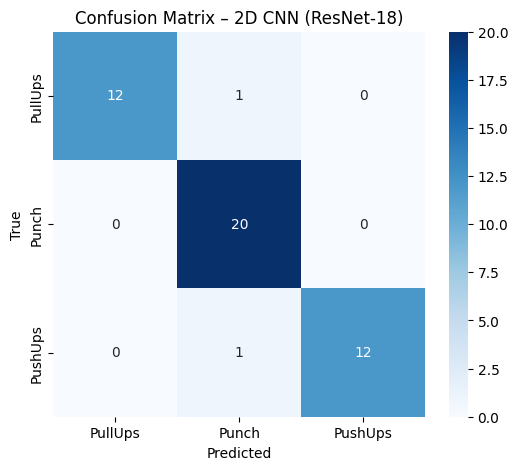

In [12]:
conf_matrix_2d = confusion_matrix(all_labels_2d, all_preds_2d)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_2d, annot=True, fmt="d",
            xticklabels=class_map.keys(),
            yticklabels=class_map.keys(),
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – 2D CNN (ResNet-18)")
plt.savefig("../results/confusion_matrices/deep_learning/2d_resnet18_confusion_matrix.png")
plt.show()
plt.close();



2D CNN: Learning curves

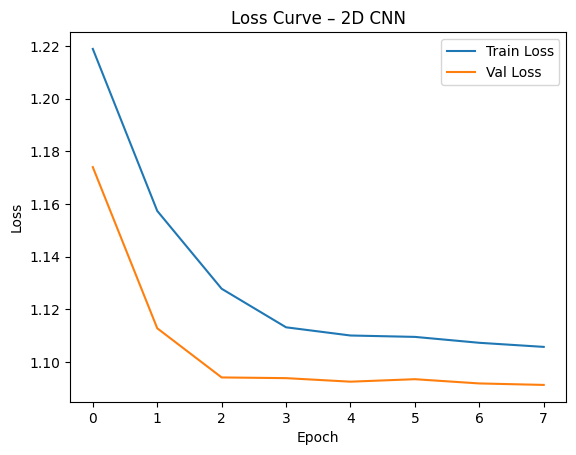

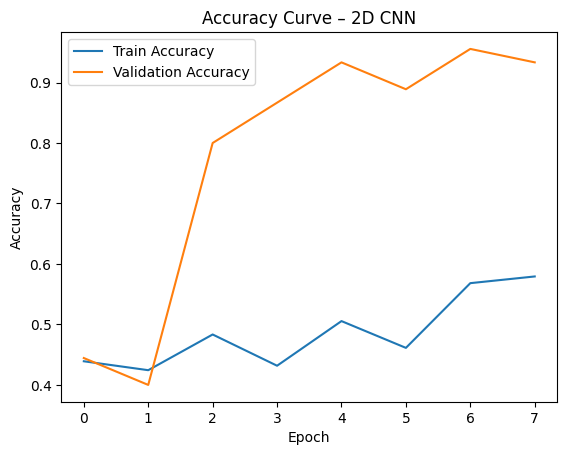

In [13]:
#print("Train losses:", train_losses_2d)
#print("Val losses:", val_losses_2d)
#print("Train accs:", train_accs_2d)
#print("Val accs:", val_accs_2d)

#print(len(train_losses_2d), len(val_losses_2d), len(train_accs_2d), len(val_accs_2d))


plt.figure()
plt.plot(train_losses_2d, label="Train Loss")
plt.plot(val_losses_2d, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve – 2D CNN")
plt.legend()
plt.savefig("../results/performance_plots/deep_learning/2d_cnn_loss_curve.png", dpi=300, bbox_inches="tight");
plt.show()
plt.close()

plt.figure()
plt.plot(train_accs_2d, label="Train Accuracy")
plt.plot(val_accs_2d, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve – 2D CNN")
plt.legend()



plt.savefig("../results/performance_plots/deep_learning/2d_cnn_accuracy_curve.png", dpi=300, bbox_inches="tight");
plt.show()
plt.close()

2D CNN: Inference time (computational analysis)

In [14]:
x, y = next(iter(test_loader_2d));
x = x.to(device);

start = time.time();
with torch.no_grad():
    _ = model_2d(x)
end = time.time();

inf_time_2d = (end - start) / x.size(0)  ;

np.save("../results/stats_deep_learning/inf_time_2d.npy", inf_time_2d);
print("Inference time per batch (seconds):", end-start);
print("Approx inference time per video (seconds)):", inf_time_2d);


Inference time per batch (seconds): 1.9521634578704834
Approx inference time per video (seconds)): 0.48804086446762085


2D CNN: Model size (parameter count)

In [15]:
total_params_2d = sum(p.numel() for p in model_2d.parameters())
trainable_params_2d = sum(p.numel() for p in model_2d.parameters() if p.requires_grad)

print("Total parameters:", total_params_2d)
print("Trainable parameters:", trainable_params_2d)


Total parameters: 11178051
Trainable parameters: 11178051


2D CNN: Error analysis

In [16]:
wrong_idx = np.where(all_preds_2d != all_labels_2d)[0]
print("Wrong predictions:", len(wrong_idx))

if len(wrong_idx) > 0:
    for i in wrong_idx[:5]:

        row = test_ds_2d.data.iloc[i]   # CSV row
        video_path = row["clip_path"]

        true_label = list(class_map.keys())[all_labels_2d[i]]
        pred_label = list(class_map.keys())[all_preds_2d[i]]

        print("Video:", video_path)
        print("True:", true_label, "| Pred:", pred_label)
        print("-"*50)


Wrong predictions: 2
Video: /PullUps/v_PullUps_g07_c04.avi
True: PullUps | Pred: Punch
--------------------------------------------------
Video: /PushUps/v_PushUps_g07_c04.avi
True: PushUps | Pred: Punch
--------------------------------------------------


2D CNN: File size on disk

In [17]:
model_path = MODEL_2D_PATH
file_size_mb_2d = os.path.getsize(model_path) / (1024 * 1024)
np.save("../results/stats_deep_learning/model_size_2d.npy", file_size_mb_2d)
print("Saved model file size: {:.2f} MB".format(file_size_mb_2d))


Saved model file size: 42.72 MB


2D CNN: Memory usage

In [18]:
print("CUDA available:", torch.cuda.is_available())
print("Torch CUDA version:", torch.version.cuda)
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


if torch.cuda.is_available():
    print("GPU memory allocated:",
          torch.cuda.memory_allocated() / (1024**2), "MB")
    print("GPU memory reserved:",
          torch.cuda.memory_reserved() / (1024**2), "MB")

process = psutil.Process(os.getpid())
ram_mb = process.memory_info().rss / (1024 * 1024)

print("Current RAM usage:", ram_mb, "MB")


CUDA available: False
Torch CUDA version: None
GPU name: No GPU detected
Current RAM usage: 3266.21875 MB


2D CNN: Saving the results for comparitive analyisis

In [19]:
acc2d = accuracy_score(all_labels_2d, all_preds_2d)
p2d, r2d, f12d, _ = precision_recall_fscore_support(all_labels_2d, all_preds_2d, average="macro")

stats_2d = {
    "accuracy": acc2d,
    "precision": p2d,
    "recall": r2d,
    "f1": f12d,
    "inference_time": inf_time_2d,
    "params": total_params_2d,
    "model_size_mb": file_size_mb_2d
}

with open("../results/stats_deep_learning/stats_2d.json", "w") as f:
    json.dump(stats_2d, f, indent=4)


2. 3D Convolutional Networks
   
- I3D Architecture
- Implement or use pre-trained 3D CNN
- Process video clips (e.g., 16 frames) as 3D volumes
- Fine-tune on your dataset

3D CNN: Dataloaders

In [20]:
train_ds_3d = VideoDataset3D("../dataset_info/dataset/splits/train.csv", dataset_root, class_map,
                             num_frames=16, transform=train_tfms, train=True)

val_ds_3d   = VideoDataset3D("../dataset_info/dataset/splits/val.csv", dataset_root, class_map,
                             num_frames=16, transform=val_tfms, train=False)

test_ds_3d  = VideoDataset3D("../dataset_info/dataset/splits/test.csv", dataset_root, class_map,
                             num_frames=16, transform=val_tfms, train=False)

train_loader_3d = DataLoader(train_ds_3d, batch_size=2, shuffle=True, num_workers=4)
val_loader_3d   = DataLoader(val_ds_3d, batch_size=2, shuffle=False, num_workers=4)
test_loader_3d  = DataLoader(test_ds_3d, batch_size=2, shuffle=False, num_workers=4)


x3d, _ = next(iter(test_loader_3d))
print(x3d.shape)

torch.Size([2, 3, 16, 224, 224])


3D CNN: Model, loss, optimizer

In [21]:
class_map = {"PullUps": 0, "Punch": 1, "PushUps": 2}
num_classes = len(class_map)


device = "cuda" if torch.cuda.is_available() else "cpu"

model_3d = ResNet3D(num_classes=num_classes, dropout=0.5, freeze_backbone=True).to(device)

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.9)
# Using Adam as optimizer
optimizer = torch.optim.Adam(model_3d.parameters(), lr=1e-4, weight_decay=1e-4)
# Learning rate scheduling
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
# Early stopping
early_stop = EarlyStopping(patience=4)

out = model_3d(x3d.to(device))
print(out.shape)

torch.Size([2, 3])


3D CNN: Training loop (With early stopping)
- This will take around 30 minutes to complete

In [22]:
start_time = time.time()

EPOCHS = 8
best_val_acc = 0.0

train_losses_3d = []
val_losses_3d   = []
train_accs_3d   = []
val_accs_3d     = []

# ================= LOAD IF EXISTS =================
if os.path.exists(MODEL_3D_PATH):

    print("Found saved 3D model. Loading...")

    model_3d.load_state_dict(torch.load(MODEL_3D_PATH, map_location=device))
    model_3d.to(device)
    model_3d.eval()

    if os.path.exists(STATS_3D_PATH):
        with open(STATS_3D_PATH, "r") as f:
            stats = json.load(f)

        # ---- SAFE LOAD ----
        train_losses_3d = stats.get("train_losses", [])
        val_losses_3d   = stats.get("val_losses", [])
        train_accs_3d   = stats.get("train_accs", [])
        val_accs_3d     = stats.get("val_accs", [])
        best_val_acc    = max(val_accs_3d) if len(val_accs_3d) > 0 else 0.0

        print("Loaded training curves from stats_3d.json")
    else:
        print("stats_3d.json not found → curves unavailable")

# ================= TRAIN IF NOT EXISTS =================
else:
    print("No saved 3D model found. Starting training...")

    for epoch in trange(EPOCHS, desc="3D CNN Epochs"):

        train_loss, train_acc = train_one_epoch(
            model_3d, train_loader_3d, optimizer, criterion, device)

        val_loss, val_acc = eval_one_epoch(
            model_3d, val_loader_3d, criterion, device)

        scheduler.step()

        print(
            f"\nEpoch [{epoch+1}/{EPOCHS}] "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} || "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
        )

        train_losses_3d.append(train_loss)
        val_losses_3d.append(val_loss)
        train_accs_3d.append(train_acc)
        val_accs_3d.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model_3d.state_dict(), MODEL_3D_PATH)

        early_stop(val_loss)
        if early_stop.stop:
            print("⏹ Early stopping triggered")
            break

    print("3D CNN Training complete. Best Val Acc:", best_val_acc)

    # ================= SAVE TRAINING CURVES =================
    stats_3d = {
        "train_losses": train_losses_3d,
        "val_losses": val_losses_3d,
        "train_accs": train_accs_3d,
        "val_accs": val_accs_3d,
        "best_val_acc": best_val_acc
    }

    with open(STATS_3D_PATH, "w") as f:
        json.dump(stats_3d, f, indent=4)

    print("Training curves saved to stats_3d.json")

end_time = time.time()
train_time_3d = end_time - start_time

np.save("../results/stats_deep_learning/train_time_3d.npy", train_time_3d)

print("3D CNN Training Time (seconds):", train_time_3d)


No saved 3D model found. Starting training...


3D CNN Epochs:  12%|█▎        | 1/8 [08:47<1:01:35, 527.96s/it]


Epoch [1/8] Train Loss: 1.1636 | Train Acc: 0.3542 || Val Loss: 1.1350 | Val Acc: 0.4222


3D CNN Epochs:  25%|██▌       | 2/8 [17:29<52:24, 524.15s/it]  


Epoch [2/8] Train Loss: 1.1577 | Train Acc: 0.3764 || Val Loss: 1.1366 | Val Acc: 0.4222


3D CNN Epochs:  38%|███▊      | 3/8 [25:45<42:36, 511.37s/it]


Epoch [3/8] Train Loss: 1.1526 | Train Acc: 0.3579 || Val Loss: 1.1120 | Val Acc: 0.5111


3D CNN Epochs:  50%|█████     | 4/8 [33:41<33:10, 497.52s/it]


Epoch [4/8] Train Loss: 1.1503 | Train Acc: 0.3506 || Val Loss: 1.1140 | Val Acc: 0.5778


3D CNN Epochs:  62%|██████▎   | 5/8 [41:40<24:32, 490.77s/it]


Epoch [5/8] Train Loss: 1.1443 | Train Acc: 0.4096 || Val Loss: 1.1172 | Val Acc: 0.4889


3D CNN Epochs:  75%|███████▌  | 6/8 [49:39<16:13, 486.79s/it]


Epoch [6/8] Train Loss: 1.1479 | Train Acc: 0.3948 || Val Loss: 1.1139 | Val Acc: 0.4667


3D CNN Epochs:  88%|████████▊ | 7/8 [57:38<08:04, 484.29s/it]


Epoch [7/8] Train Loss: 1.1417 | Train Acc: 0.3321 || Val Loss: 1.1102 | Val Acc: 0.6444


3D CNN Epochs: 100%|██████████| 8/8 [1:05:36<00:00, 492.10s/it]


Epoch [8/8] Train Loss: 1.1484 | Train Acc: 0.3506 || Val Loss: 1.1082 | Val Acc: 0.5778
3D CNN Training complete. Best Val Acc: 0.6444444444444445
Training curves saved to stats_3d.json
3D CNN Training Time (seconds): 3936.8292112350464


3D CNN: Loading best model

In [23]:
model_3d.load_state_dict(torch.load(MODEL_3D_PATH, map_location=device))
model_3d.eval()

print("Model loaded successfully")
print("Backbone: ResNet-3D (r3d_18, Kinetics pretrained)")
print("Input: video clips as 3D volumes (C × T × H × W)")
print("Temporal modeling: 3D convolutions")
print("Classifier head: Dropout → Fully Connected (3 classes)")

print("Trainable parameters:",
      sum(p.numel() for p in model_3d.parameters() if p.requires_grad))

print("Total parameters:",
      sum(p.numel() for p in model_3d.parameters()))


Model loaded successfully
Backbone: ResNet-3D (r3d_18, Kinetics pretrained)
Input: video clips as 3D volumes (C × T × H × W)
Temporal modeling: 3D convolutions
Classifier head: Dropout → Fully Connected (3 classes)
Trainable parameters: 1539
Total parameters: 33167811


3D CNN: Test set evaluation

In [24]:
model_3d.load_state_dict(torch.load(MODEL_3D_PATH, map_location=device))
model_3d.eval()

all_preds_3d, all_labels_3d = [], []

with torch.no_grad():
    for x, y in test_loader_3d:
        x, y = x.to(device), y.to(device)
        out = model_3d(x)
        preds = torch.argmax(out, dim=1)

        all_preds_3d.extend(preds.cpu().numpy())
        all_labels_3d.extend(y.cpu().numpy())



3D CNN: Evaluation metrices

In [25]:
print("3D CNN Test Accuracy:", accuracy_score(all_labels_3d, all_preds_3d))
print("\nClassification Report:")
print(classification_report(all_labels_3d, all_preds_3d, target_names=class_map.keys()))

3D CNN Test Accuracy: 0.5

Classification Report:
              precision    recall  f1-score   support

     PullUps       0.45      0.38      0.42        13
       Punch       0.50      0.70      0.58        20
     PushUps       0.57      0.31      0.40        13

    accuracy                           0.50        46
   macro avg       0.51      0.46      0.47        46
weighted avg       0.51      0.50      0.48        46



3D CNN: Confusion Matrix

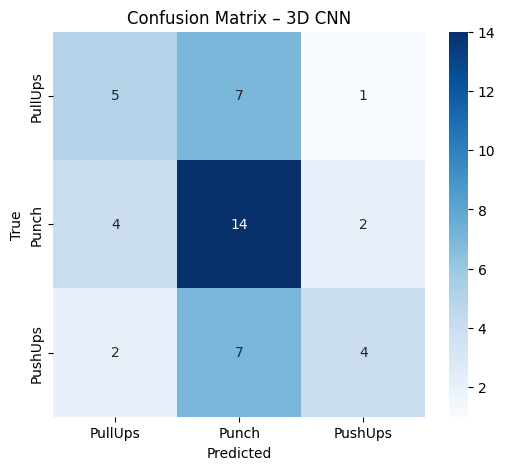

In [26]:
conf_matrix_3d = confusion_matrix(all_labels_3d, all_preds_3d)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_3d, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_map.keys(),
            yticklabels=class_map.keys())
plt.title("Confusion Matrix – 3D CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("../results/confusion_matrices/deep_learning/3d_resnet3d_confusion_matrix.png");
plt.show()
plt.close()

3D CNN: Learning curves

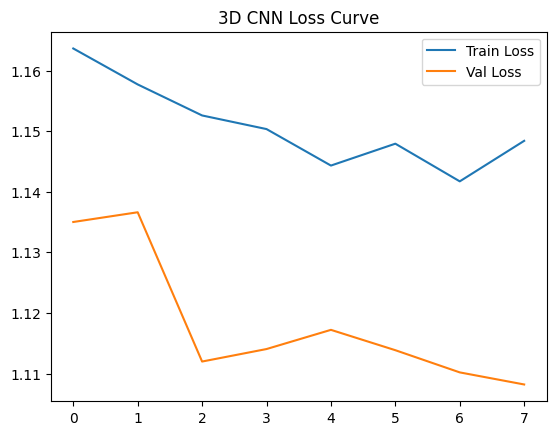

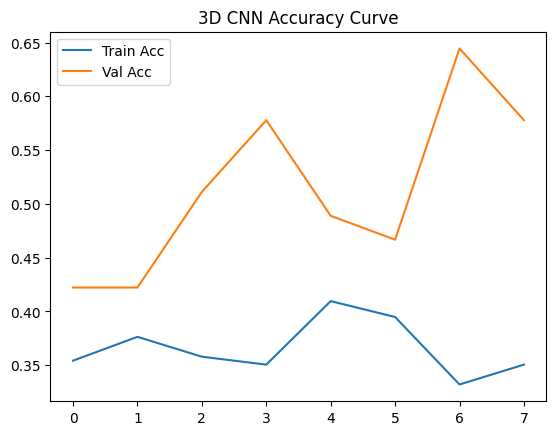

In [27]:
plt.figure()
plt.plot(train_losses_3d, label="Train Loss")
plt.plot(val_losses_3d, label="Val Loss")
plt.title("3D CNN Loss Curve")
plt.legend()
plt.savefig("../results/performance_plots/deep_learning/3d_cnn_loss_curve.png");
plt.show()
plt.close()

plt.figure()
plt.plot(train_accs_3d, label="Train Acc")
plt.plot(val_accs_3d, label="Val Acc")
plt.title("3D CNN Accuracy Curve")
plt.legend()
plt.savefig("../results/performance_plots/deep_learning/3d_cnn_accuracy_curve.png");
plt.show()


3D CNN: Inference time (computational analysis)

In [28]:
x, y = next(iter(test_loader_3d))
x = x.to(device)

start = time.time()
with torch.no_grad():
    _ = model_3d(x)
end = time.time()

inf_time_3d = (end - start) / x.size(0)  

np.save("../results/stats_deep_learning/inf_time_3d.npy", inf_time_3d)
print("Inference time per batch:", end-start)
print("Approx inference time per video:", inf_time_3d)


Inference time per batch: 2.5213372707366943
Approx inference time per video: 1.2606686353683472


3D CNN: Model size (parameter count)

In [29]:
total_params_3d = sum(p.numel() for p in model_3d.parameters())
trainable_params_3d = sum(p.numel() for p in model_3d.parameters() if p.requires_grad)

print("3D CNN Total parameters:", total_params_3d)
print("3D CNN Trainable parameters:", trainable_params_3d)


3D CNN Total parameters: 33167811
3D CNN Trainable parameters: 1539


3D CNN: Error Analysis

In [30]:
wrong_idx = np.where(np.array(all_preds_3d) != np.array(all_labels_3d))[0]
print("Total wrong predictions (3D CNN):", len(wrong_idx))

if len(wrong_idx) > 0:
    #for i in wrong_idx[:5]:
    for i in wrong_idx:    
        row = test_ds_3d.data.iloc[i]
        video_path = row["clip_path"]

        true_label = list(class_map.keys())[all_labels_3d[i]]
        pred_label = list(class_map.keys())[all_preds_3d[i]]

        print("Video:", video_path)
        print("True:", true_label, "| Pred:", pred_label)
        print("-"*50)


Total wrong predictions (3D CNN): 23
Video: /PullUps/v_PullUps_g19_c02.avi
True: PullUps | Pred: Punch
--------------------------------------------------
Video: /PullUps/v_PullUps_g02_c04.avi
True: PullUps | Pred: Punch
--------------------------------------------------
Video: /PullUps/v_PullUps_g16_c01.avi
True: PullUps | Pred: PushUps
--------------------------------------------------
Video: /PullUps/v_PullUps_g09_c01.avi
True: PullUps | Pred: Punch
--------------------------------------------------
Video: /PullUps/v_PullUps_g17_c01.avi
True: PullUps | Pred: Punch
--------------------------------------------------
Video: /PullUps/v_PullUps_g11_c02.avi
True: PullUps | Pred: Punch
--------------------------------------------------
Video: /PullUps/v_PullUps_g09_c03.avi
True: PullUps | Pred: Punch
--------------------------------------------------
Video: /PullUps/v_PullUps_g06_c04.avi
True: PullUps | Pred: Punch
--------------------------------------------------
Video: /Punch/v_Punch_g07

3D CNN: File size on disk

In [31]:
model_path = MODEL_3D_PATH
file_size_mb_3d = os.path.getsize(model_path) / (1024 * 1024)
np.save("../results/stats_deep_learning/model_size_3d.npy", file_size_mb_3d)
print("3D CNN Saved model size: {:.2f} MB".format(file_size_mb_3d))

3D CNN Saved model size: 126.60 MB


3D CNN: Memory Usage

In [32]:
if torch.cuda.is_available():
    print("GPU memory allocated:",
          torch.cuda.memory_allocated() / (1024**2), "MB")
    print("GPU memory reserved:",
          torch.cuda.memory_reserved() / (1024**2), "MB")
else:
    print("GPU not available. Running on CPU.")

process = psutil.Process(os.getpid())
ram_mb = process.memory_info().rss / (1024 * 1024)

print("Current CPU RAM usage: {:.2f} MB".format(ram_mb))


GPU not available. Running on CPU.
Current CPU RAM usage: 3276.68 MB


3D CNN: Saving the results for comparitive analyisis

In [33]:
acc3d = accuracy_score(all_labels_3d, all_preds_3d)
p3d, r3d, f13d, _ = precision_recall_fscore_support(all_labels_3d, all_preds_3d, average="macro")

stats_3d = {
    "accuracy": acc3d,
    "precision": p3d,
    "recall": r3d,
    "f1": f13d,
    "inference_time": inf_time_3d,
    "params": total_params_3d,
    "model_size_mb": file_size_mb_3d
}

with open("../results/stats_deep_learning/stats_3d.json", "w") as f:
    json.dump(stats_3d, f, indent=4)


In [34]:
np.save("../results/stats_deep_learning/preds_2d.npy", all_preds_2d)
np.save("../results/stats_deep_learning/labels_2d.npy", all_labels_2d)

np.save("../results/stats_deep_learning/preds_3d.npy", all_preds_3d)
np.save("../results/stats_deep_learning/labels_3d.npy", all_labels_3d)
